
### NOTE: this code computes FFSI from scratch, see 5.1 for computing using pre-processed HAND

# Determination of FFSI

https://www.nat-hazards-earth-syst-sci.net/15/1907/2015/nhess-15-1907-2015.pdf
https://www.researchgate.net/publication/301559649_Global_30m_Height_Above_the_Nearest_Drainage

Determination of Flash Flood Susceptibility Index (FFSI) from digital elevation data and soil physical properties. The index consists of three components:

1. A cost component 
  * This number represents the costs of flooding and is constructed using HAND and distance to the nearest stream
2. A soil hazard component.
  * It is constucted using the amoutn of water can than be stored in the soil (porosity * depth) and the soil infiltration cpacity)
3. A slope/upstream component
    * This is a combination of the upstream area and the average upstream  slope for each cell

The final index is the sum of the slope/upstream and the soil components multiplied by the costs component.

FFSI = (SoilHaz + slopeHaz) * (1 - cost)

In [66]:
%pylab inline
from pcraster import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# First define some helper functions (to derive HAND ect)

In [67]:

def derive_HAND(dem, ldd, accuThreshold, rivers=None, basin=None):
    """
    Function derives Height-Above-Nearest-Drain.
    See http://www.sciencedirect.com/science/article/pii/S003442570800120X
    Input:
        dem -- pcraster object float32, elevation data
        ldd -- pcraster object direction, local drain directions
        accuThreshold -- upstream amount of cells as threshold for river
            delineation
        rivers=None -- you can provide a rivers layer here. Pixels that are 
                        identified as river should have a value > 0, other
                        pixels a value of zero.
        basin=None -- set a boolean pcraster map where areas with True are estimated using the nearest drain in ldd distance
                        and areas with False by means of the nearest friction distance. Friction distance estimated using the 
                        upstream area as weight (i.e. drains with a bigger upstream area have a lower friction)
                        the spreadzone operator is used in this case.
    Output:
        hand -- pcraster bject float32, height, normalised to nearest stream
        dist -- distance to nearest stream measured in cell lengths
            according to D8 directions
    """
    if rivers is None:
        stream = ifthenelse(accuflux(ldd, 1) >= accuThreshold,
                                boolean(1), boolean(0))
    else:
        stream = boolean(cover(rivers, 0))
    
    height_river = ifthenelse(stream, ordinal(dem*100), 0)
    if basin is None:
        up_elevation = scalar(subcatchment(ldd, height_river))
    else:
        drainage_surf = ifthen(rivers, accuflux(ldd, 1))
        weight = 1./scalar(spreadzone(cover(ordinal(drainage_surf), 0), 0, 0))
        up_elevation = ifthenelse(basin, scalar(subcatchment(ldd, height_river)), scalar(spreadzone(height_river, 0, weight)))
        # replace areas outside of basin by a spread zone calculation.
    hand = max(scalar(ordinal(dem*100))-up_elevation, 0)/100
    dist = ldddist(ldd, stream, 1)
        
    return hand, dist, stream

def lattometres(lat):
    """"
    Determines the length of one degree lat/long at a given latitude (in meter).
    Code taken from http:www.nga.mil/MSISiteContent/StaticFiles/Calculators/degree.html
    Input: map with lattitude values for each cell
    Returns: length of a cell lat, length of a cell long
    """
    #radlat = spatial(lat * ((2.0 * math.pi)/360.0))
    #radlat = lat * (2.0 * math.pi)/360.0
    radlat = spatial(lat) # pcraster cos/sin work in degrees!
    
    
    m1 = 111132.92        # latitude calculation term 1
    m2 = -559.82        # latitude calculation term 2
    m3 = 1.175            # latitude calculation term 3
    m4 = -0.0023        # latitude calculation term 4
    p1 = 111412.84        # longitude calculation term 1
    p2 = -93.5            # longitude calculation term 2
    p3 = 0.118            # longitude calculation term 3
    # # Calculate the length of a degree of latitude and longitude in meters
    
    latlen = m1 + (m2 * cos(2.0 * radlat)) + (m3 * cos(4.0 * radlat)) + (m4 * cos(6.0 * radlat))
    longlen = (p1 * cos(radlat)) + (p2 * cos(3.0 * radlat)) + (p3 * cos(5.0 * radlat))
        
    return latlen, longlen  

def detRealCellLength(ZeroMap,sizeinmetres):
    """
    Determine cellength. Always returns the length
    in meters.
    """
    
    if sizeinmetres:
            reallength = celllength()
            xl = celllength()
            yl = celllength()
    else:
        aa = ycoordinate(boolean(cover(ZeroMap + 1,1)))
        yl, xl = lattometres(aa)
           
        xl = xl * celllength()
        yl = yl * celllength()
        # Average length for surface area calculations. 
        
        reallength = (xl + yl) * 0.5
        
    return xl,yl,reallength



def norm(x):
    mmin = mapminimum(x)
    mmax = mapmaximum(x)
    
    return  (x - mmin)/(mmax - mmin)

def showmap(map,mtitle='Map'):
    imshow(pcr_as_numpy(map))
    title(mtitle)
    colorbar()
figsize(8, 8)    

# Determination of the FFSI
## Set the weight parameter of the different components of the index

In [68]:
f1 = 0.8 # Weight of hand in the cost parameter
f2 = 0.1 # Weight of distance in the cost parameter

f3 = 0.2 # Weight of upstream area in the upstream hazzard
f4 = 0.8 # Weight of upstream slope in the upstream hazzard


f5 = 0.4 # Weight of soildepth in the upstream soil hazzard
f6 = 0.6 # Weight of soilinfiltrationcapacity in the upstream soil hazzard

f7 = 0.7 # Weight of upstream hazzard in the index
f8 = 0.3 # Weight of upstream soil hazzard in the index

## Read the DEM and LDD

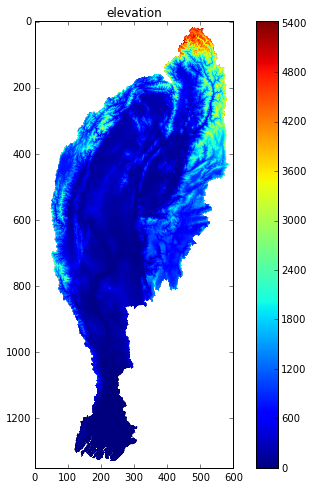

In [69]:
ldd = readmap("wflow_ldd.map")

dem = readmap("wflow_dem.map")
showmap(dem,'elevation')

Derive HAND and distance to nearest stream. As this DEM is in lat/lon convert to meters also.

In [70]:
hnd, dst, strr  = derive_HAND(dem,ldd,30) 

x,y, rl = detRealCellLength(dem,0)

dst = dst * rl/celllength()

# Now try to scale between 0 and 1
#hnd = hnd/mapmaximum(hnd)
#dst = dst/mapmaximum(dst)


Normalize the hand and distance to a value between 0 and 1. Next determien the 'cost' of flooding as the sum of hand and distance. Apply weights to both HAND and distance. Finally normalise the cost function between 0 and 1

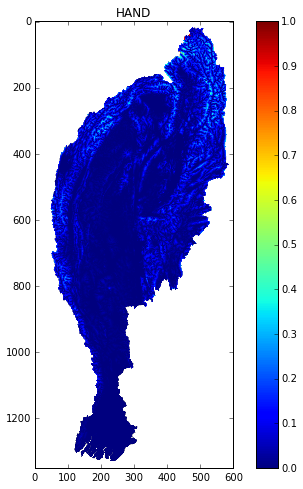

In [71]:
hnd = norm(hnd)
dst=norm(dst)

cost= hnd*f1 + dst*f2
cost = norm(cost)
showmap(hnd,'HAND')

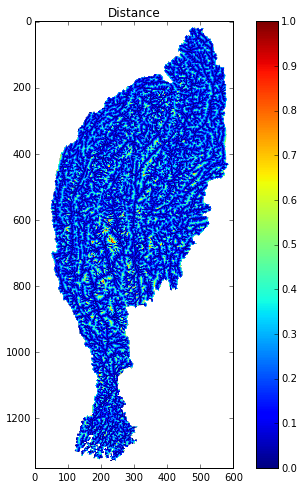

In [72]:
showmap(dst,'Distance')

Save the maps

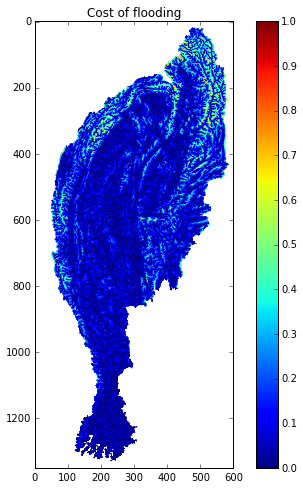

In [73]:
report(hnd,"hand.map")
report(dst,"dist.map")
report(cost,"_cost.map")
report(strr,"strrr.map")
showmap(cost,'Cost of flooding')

## Determine the soil hazard

Now read the soil data. Soil data used consists of:

- a total soil depth, 
- soil porosity
- soil infiltration capacity (Ksat in mm/d)



In [74]:
depth = readmap("DEPTH.map")
#remove see stuf (depth = 0) from maps
depth = ifthenelse(depth <=0.0001,500,depth)
ksat = readmap("KSAT.map")
ksat = ifthenelse(ksat <=0.0001,100,ksat)
poros = readmap("poros.map")
poros = ifthenelse(poros <=0.0001,0.4,poros)

Now determine the soil depth hazard by calculating the water holding capacity of the soil (depth * porosity) and normalise this between 0 and 1. 

The soil infonfiltration hazard is determined as follows:

- determine excess infiltration by subtracting the infiltration capacity from the unit storm (100m in this case)
- normalise this netween 0 and 1

The combined soil hazard is determine by adding the depth and infiltration hazard (while applying weights for each component), normalize this between 0 and 1 and determine the upstream average (for each cell) of this number.


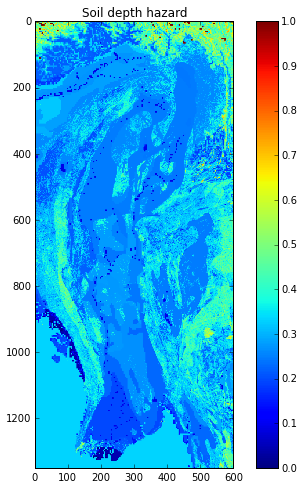

In [75]:
soildhaz = max(0.0,depth * poros - 100)
soildhaz = 1 - norm(soildhaz)
report(soildhaz,"soildhaz.map")
showmap(soildhaz,'Soil depth hazard')

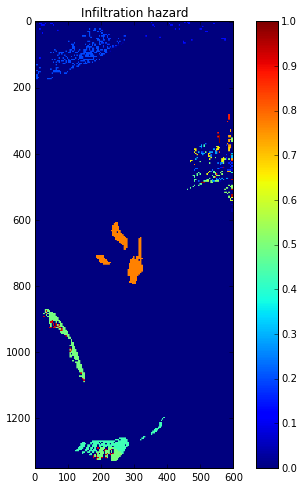

In [76]:
soilinfhaz = max(0.0,100 - ksat)
soilinfhaz = norm(soilinfhaz)
report(soilinfhaz,"soilinfhaz.map")
showmap(soilinfhaz,'Infiltration hazard')

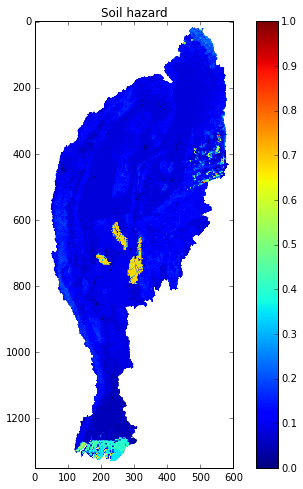

In [77]:
soilhaz = (f5 * soildhaz) + (soilinfhaz * f6)
soilhaz = norm(soilhaz)

report(soilhaz,"soilhaz.map")

soilhazupstr = norm(catchmenttotal(soilhaz,ldd)/catchmenttotal(1.0,ldd))
report(soilhazupstr,"_soilhazupstr.map")
showmap(soilhazupstr,'Soil hazard')

## Determine the slope hazard

First determine the upstream area (maximise to 100km^2), determine the log and scale this betwen 0 and 1

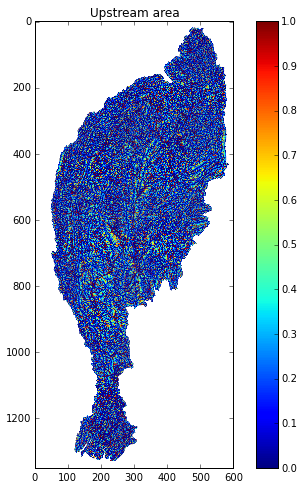

In [78]:
# upstream are maxed at 100km^2
upstr = catchmenttotal(1.0,ldd)
maxupstr = 100. * (1000. * 1000.) # 100 sqr km
upstr = ln(min(maxupstr,upstr * rl * rl))
upstr = norm(upstr)
showmap(upstr,'Upstream area')

1. Determine the slope in each cell (correct of the celles are in lat/lon). 
2. determine the average slope for all the upstream cells and normalise between 0 and 1

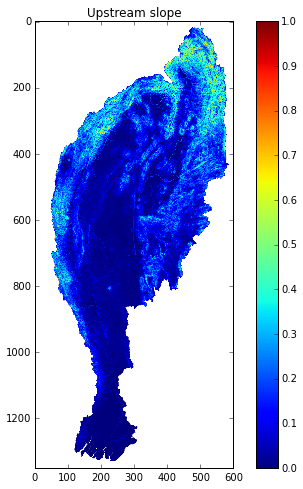

In [79]:
theslope = slope(dem)
theslope = max(0.00001, theslope * celllength() / rl)
ustrslope = catchmenttotal(theslope,ldd)/catchmenttotal(1.0,ldd)
ustrslope = norm(ustrslope)
showmap(ustrslope,'Upstream slope')

Combine the upstream area and slope components into a single number and apply weigths for the two components

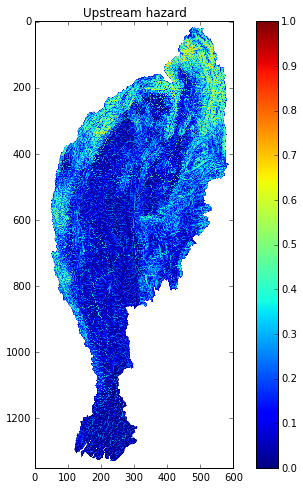

In [80]:
# more weigth to upstr -> river flooding, more weigth to slope, flash flooding
report(upstr,"upstr.map")
report(ustrslope,"ustrslope.map")
upstrhaz = (f3 * upstr)  +  (f4 *ustrslope)
upstrhaz = norm(upstrhaz)
report(upstrhaz,"_upstrhaz.map")
showmap(upstrhaz,'Upstream hazard')

## Determine the combined hazard, the FFSI

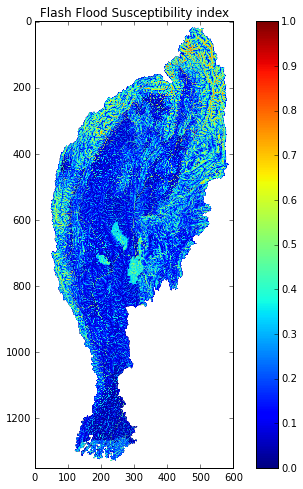

In [81]:
FFSI = (upstrhaz*f7  + soilhazupstr * f8) * (1.0- cost) 
FFSI = norm(FFSI)
report(FFSI,"FFSI.map")

idx = ifthenelse(FFSI > 0.49,scalar(1), 
                ifthenelse(FFSI > 0.41,scalar(2),
                          ifthenelse(FFSI > 0.3,scalar(3),scalar(4))))

report(nominal(idx),"_FFSI.map")
showmap(FFSI,'Flash Flood Susceptibility index')